### SVM Hands on Exercise 

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score
import shap
import pyarrow

In [2]:
# Reading the dataset
df = pd.read_parquet('final_dataset.parquet')

# Replacing NaN values with 0
df = df.fillna(0)

In [3]:
df.head()

,date,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_pca,st_pca,target
0,2010-02-14,0.0,36,13,20.52,136.0,3.619512,0.190574,0
1,2010-02-15,0.0,41,7,20.51,129.0,3.470118,0.209177,0
2,2010-02-16,0.0,43,8,20.51,130.0,3.433721,0.197542,0
3,2010-02-17,0.0,51,10,20.51,132.0,3.351107,0.135033,0
4,2010-02-18,0.0,51,16,20.50,135.0,3.238121,0.107690,0


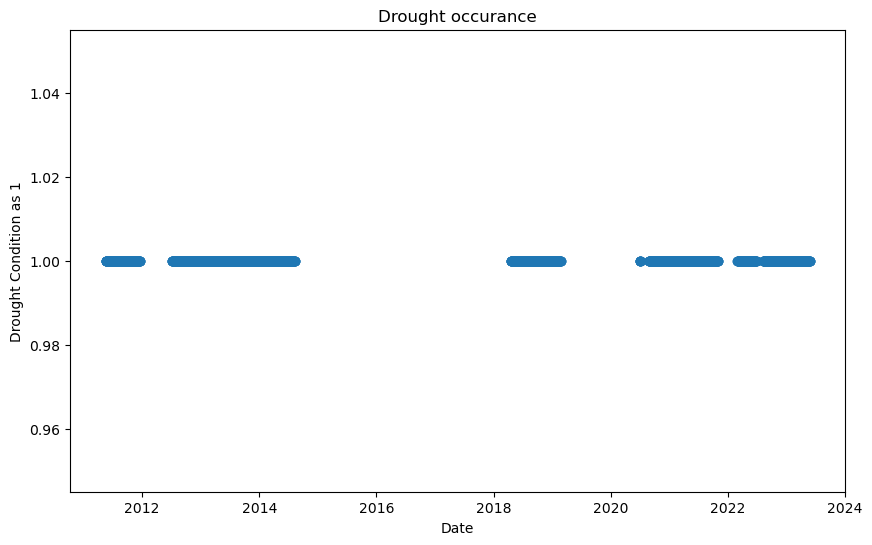

In [4]:
# Visualizing where target variable is 1 i.e there is drought

plt.figure(figsize=(10, 6))
plt.scatter(df[df['target'] == 1]['date'], df[df['target'] == 1]['target'])
plt.title('Drought occurance')
plt.xlabel('Date')
plt.ylabel('Drought Condition as 1')
plt.show()

In [5]:
# following are the features list

features = ['precip', 'max_temp', 'min_temp', 'gwl', 'daily_discharge_cfs','sm_pca', 'st_pca']
target = 'target'

In [6]:
# Checking for multicollinearity between features

corr = df[features].corr()
corr.style.background_gradient(cmap='coolwarm')

,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_pca,st_pca
precip,1.000000,-0.032593,0.104749,-0.024576,0.206089,-0.024596,-0.001298
max_temp,-0.032593,1.000000,0.861268,0.063881,0.010227,-0.390845,-0.302978
min_temp,0.104749,0.861268,1.000000,0.046226,0.101598,-0.406750,-0.333921
gwl,-0.024576,0.063881,0.046226,1.000000,-0.056801,0.019720,-0.452011
daily_discharge_cfs,0.206089,0.010227,0.101598,-0.056801,1.000000,0.024787,0.018521
sm_pca,-0.024596,-0.390845,-0.406750,0.019720,0.024787,1.000000,0.312463
st_pca,-0.001298,-0.302978,-0.333921,-0.452011,0.018521,0.312463,1.000000


We can see that there is correlation between max_temp and min_temp, but as per the domain knowledge, we know that these two features are important and we should keep them.

In [7]:
# Displaying the data before splitting

display(df[features].head())

display(df[[target]].head())

,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_pca,st_pca
0,0.0,36,13,20.52,136.0,3.619512,0.190574
1,0.0,41,7,20.51,129.0,3.470118,0.209177
2,0.0,43,8,20.51,130.0,3.433721,0.197542
3,0.0,51,10,20.51,132.0,3.351107,0.135033
4,0.0,51,16,20.50,135.0,3.238121,0.107690


,target
0,0
1,0
2,0
3,0
4,0


In [8]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.2, random_state = 0)

In [9]:
# No. of instance with 1 in target variable for training set
display(y_train.value_counts())

# No. of instance with 1 in target variable for test set
display(y_test.value_counts())

0    2218
1    1686
Name: target, dtype: int64

0    536
1    441
Name: target, dtype: int64

In [10]:
# display the data after splitting

# Training set
display(pd.DataFrame(X_train).head())
display(pd.DataFrame(y_train).head())

# Test set
display(pd.DataFrame(X_test).head())
display(pd.DataFrame(y_test).head())


,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_pca,st_pca
641,0.00,57,11,21.00,145.0,0.494067,-1.976446
333,0.11,35,19,20.84,93.7,-0.995163,0.067906
33,0.08,40,25,20.44,120.0,-0.179378,1.826560
3909,0.00,41,8,21.71,96.9,-0.002604,1.751204
4193,0.00,62,32,22.13,150.0,0.943268,-1.191578


,target
641,1
333,0
33,0
3909,1
4193,1


,precip,max_temp,min_temp,gwl,daily_discharge_cfs,sm_pca,st_pca
2857,0.01,47,22,21.16,170.0,2.224886,2.490720
2373,0.00,75,30,21.73,100.0,0.893778,-1.718663
1065,0.00,48,17,21.00,78.3,0.303675,0.066434
2287,0.00,97,60,21.31,112.0,-0.647494,-0.541322
1675,0.00,80,42,21.45,163.0,-0.127969,-1.816134


,target
2857,0
2373,0
1065,1
2287,0
1675,0


In [11]:
# Scaling the features
# Feature scaling is performed to ensure that the model is not biased towards the features with higher magnitude

sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [12]:
# Displaying the scaled training set

display(pd.DataFrame(X_train).head())

,0,1,2,3,4,5,6
0,-0.236413,-0.703677,-1.472493,-0.789317,-0.043247,0.398965,-1.188105
1,0.574686,-1.801402,-1.034528,-1.157828,-0.211894,-0.693305,0.026048
2,0.353477,-1.551919,-0.706055,-2.079106,-0.125433,-0.094971,1.070523
3,-0.236413,-1.502023,-1.636730,0.845953,-0.201374,0.034684,1.025768
4,-0.236413,-0.454194,-0.322836,1.813295,-0.026809,0.728431,-0.721967


#### Exercise 1: Support Vector Machine with Default Parameters (Linear Kernel, Poly Kernel and Rbf Kernel)

In [13]:
from sklearn.svm import SVC

# Model building - Linear Kernel
classifier_linear = SVC(kernel='linear')
classifier_linear.fit(X_train, y_train)
pred_linear = classifier_linear.predict(sc.transform(X_test))

# Model building - Polynomial Kernel
classifier_poly = SVC(kernel='poly')
classifier_poly.fit(X_train, y_train)
pred_poly = classifier_poly.predict(sc.transform(X_test))

# Model building - RBF Kernel
classifier_rbf = SVC(kernel='rbf')
classifier_rbf.fit(X_train, y_train)
pred_rbf = classifier_rbf.predict(sc.transform(X_test))

#### Exercise 2: Generate the Confusion Matrix for all 3 kernels (Linear, Poly and Rbf)

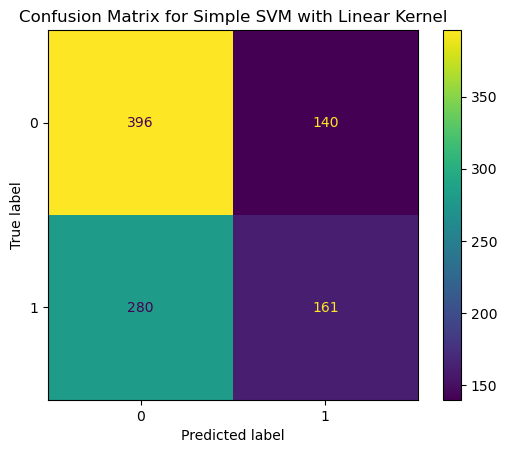

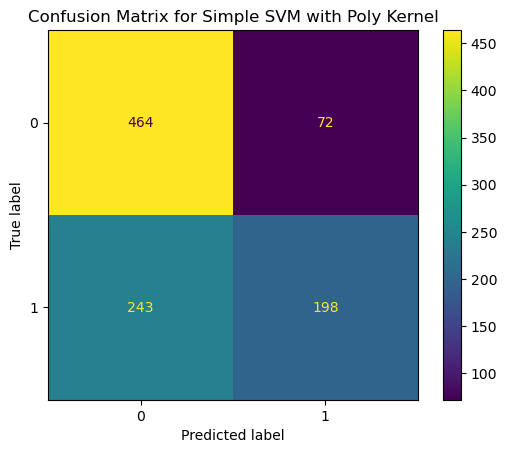

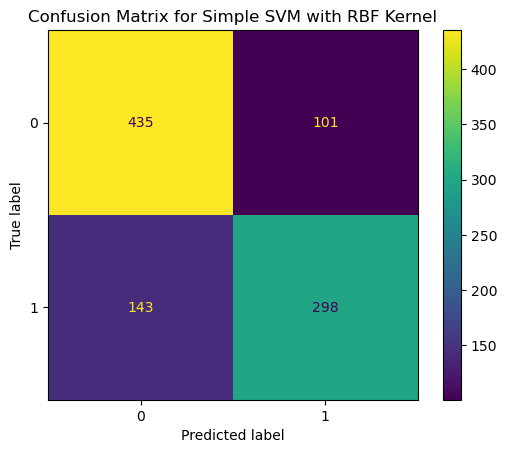

In [14]:
# Generating confusion matrices for each kernel

cm_linear = confusion_matrix(y_test, pred_linear)
disp_linear = ConfusionMatrixDisplay(confusion_matrix=cm_linear, display_labels=classifier_linear.classes_)
disp_linear.plot()
disp_linear.ax_.set_title('Confusion Matrix for Simple SVM with Linear Kernel')
plt.show()

cm_poly = confusion_matrix(y_test, pred_poly)
disp_poly = ConfusionMatrixDisplay(confusion_matrix=cm_poly, display_labels=classifier_poly.classes_)
disp_poly.plot()
disp_poly.ax_.set_title('Confusion Matrix for Simple SVM with Poly Kernel')
plt.show()

cm_rbf = confusion_matrix(y_test, pred_rbf)
disp_rbf = ConfusionMatrixDisplay(confusion_matrix=cm_rbf, display_labels=classifier_rbf.classes_)
disp_rbf.plot()
disp_rbf.ax_.set_title('Confusion Matrix for Simple SVM with RBF Kernel')
plt.show()

#### Exercise 3: Calculate the `accuracy`, `f1` score and `recall` for all 3 kernels (Linear, Poly and Rbf) and put it all in a data frame

In [15]:
# Calculating metrics for each kernel
accuracy_linear = accuracy_score(y_test, pred_linear)
f1_linear = f1_score(y_test, pred_linear)
recall_linear = recall_score(y_test, pred_linear)

accuracy_poly = accuracy_score(y_test, pred_poly)
f1_poly = f1_score(y_test, pred_poly)
recall_poly = recall_score(y_test, pred_poly)

accuracy_rbf = accuracy_score(y_test, pred_rbf)
f1_rbf = f1_score(y_test, pred_rbf)
recall_rbf = recall_score(y_test, pred_rbf)

# Creating a DataFrame for comparison
scores = pd.DataFrame({
    'Kernel': ['Linear', 'Poly', 'RBF'],
    'Accuracy': [accuracy_linear, accuracy_poly, accuracy_rbf],
    'F1 Score': [f1_linear, f1_poly, f1_rbf],
    'Recall': [recall_linear, recall_poly, recall_rbf]
})

# Displaying the scores
display(scores)

,Kernel,Accuracy,F1 Score,Recall
0,Linear,0.570113,0.433962,0.365079
1,Poly,0.677584,0.556962,0.448980
2,RBF,0.750256,0.709524,0.675737


#### Exercise 4: Optimize the model using `GridSearchCV` for `Accuracy Metric`

In [16]:
# Implementing SVM with GridSearchCV for hyperparameter tuning of linear, rbf and poly kernels

# GridSearchCV for hyperparameter tuning (Accuracy)
param_grid_acc = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500],
    'kernel': ['linear', 'poly', 'rbf']
}

svc_acc = SVC()
grid_search_acc = GridSearchCV(estimator=svc_acc, param_grid=param_grid_acc, scoring='accuracy', cv=5, n_jobs=-1)
grid_search_acc.fit(X_train, y_train)

best_accuracy = grid_search_acc.best_score_
best_parameters_acc = grid_search_acc.best_params_

print('Best Accuracy:', best_accuracy)
print('Best Parameters (Accuracy):', best_parameters_acc)




Best Accuracy: 0.879608325946354
Best Parameters (Accuracy): {'C': 500, 'kernel': 'rbf'}


#### Exercise 5: Optimize the model using `GridSearchCV` for `Recall Metric`

In [17]:
# Implementing SVM with GridSearchCV for hyperparameter tuning of linear, rbf and poly kernels

param_grid_rec = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500],
    'kernel': ['linear', 'poly', 'rbf']
}

svc_rec = SVC()
grid_search_rec = GridSearchCV(estimator=svc_rec, param_grid=param_grid_rec, scoring='recall', cv=5, n_jobs=-1)
grid_search_rec.fit(X_train, y_train)

best_recall = grid_search_rec.best_score_
best_parameters_rec = grid_search_rec.best_params_

print('Best Recall:', best_recall)
print('Best Parameters (Recall):', best_parameters_rec)

Best Recall: 0.8540831914034378
Best Parameters (Recall): {'C': 500, 'kernel': 'rbf'}


#### Exercise 6: Optimize the model using `GridSearchCV` for `F1 Metric`

In [ ]:
# Implementing SVM with GridSearchCV for hyperparameter tuning of linear, rbf and poly kernels

param_grid_f1 = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500],
    'kernel': ['linear', 'poly', 'rbf']
}

svc_f1 = SVC()
grid_search_f1 = GridSearchCV(estimator=svc_f1, param_grid=param_grid_f1, scoring='f1', cv=5, n_jobs=-1)
grid_search_f1.fit(X_train, y_train)

best_f1 = grid_search_f1.best_score_
best_parameters_f1 = grid_search_f1.best_params_

print('Best F1:', best_f1)
print('Best Parameters (F1):', best_parameters_f1)


#### Exercise 7: # Fitting best SVM model to the training set `(kernel = 'Your Choice Kernel from test results above', C = 10)`


In [ ]:
classifier = SVC(C=10, kernel='rbf')
classifier.fit(X_train, y_train)

# Predicting the Test set results
preds = classifier.predict(sc.transform(X_test))


#### Exercise 8: Generating your confusion matrix 

In [ ]:
cm = confusion_matrix(y_test,preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
disp.ax_.set_title('Confusion Matrix for Hyperparameter Tuned SVM')

#### Exercise 9: Calculating the Accuracy, F1 Score and Recall Score

In [ ]:
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
recall = recall_score(y_test, preds)



print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall Score: {recall}')